In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datatools as dtools
from time import time
#
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
import tensorflow_probability as tfp
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors



In [3]:
#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
# path = '/data2/cosmo4d/'
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
ftypefpm = 'L%04d_N%04d_S%04d_%02dstep_fpm/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]
# seeds = [100]

# Loop mehtod

# Estimator

In [4]:
cube_sizes = np.array([ 16, 32, 64])
num_cubes= 500#(500*8/cube_sizes).astype('int')
pad = 0
cube_sizesft = cube_sizes + 2*pad
max_offset = ncp - cube_sizes
ftname = ['cic']
nchannels = len(ftname)
rprob = 0.5


In [5]:

    
#############################
##Read data and generate meshes
meshes = {}
cube_features, cube_target = [[] for i in range(len(cube_sizes))], [[] for i in range(len(cube_sizes))]

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftypefpm%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, 10, kny)                                                                                                                                                                                                                                

    hmesh = {}
    ##Uncomment for galaxies
#     hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
#     hposd = tools.readbigfile(hpath + 'Position/')
#     massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
#     galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
#     hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
#     hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
#     hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
#     targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    hposd = hposall[:num].copy()
#     massd = massall[:num].copy()
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    targetmesh = [hmesh['pnn']]
#     #hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
#     #hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    ntarget = len(targetmesh)

    for i, size in enumerate(cube_sizes):
        print('For size = ', size)
        if size==nc:
            features = [np.stack(ftlistpad, axis=-1)]
            target = [np.stack(targetmesh, axis=-1)]
        else:
            numcubes = int(num_cubes/size*4)
            features, target = dtools.randomvoxels(ftlistpad, targetmesh, numcubes, max_offset[i],
                                            size, cube_sizesft[i], seed=seed, rprob=0)
        cube_features[i] = cube_features[i] + features
        cube_target[i] = cube_target[i] + target

# #
for i in range(cube_sizes.size):
    cube_target[i] = np.stack(cube_target[i],axis=0)
    cube_features[i] = np.stack(cube_features[i],axis=0)
    print(cube_features[i].shape, cube_target[i].shape)

    


All the mesh have been generated for seed = 100
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
All the mesh have been generated for seed = 200
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
All the mesh have been generated for seed = 300
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
All the mesh have been generated for seed = 400
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotati

In [6]:

def _mdn_model_fn(features, labels, n_y, n_mixture, dropout, optimizer, mode):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
        
    def _module_fn():
        """
        Function building the module
        """
    
        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')

        # Builds the neural network
        net = slim.conv3d(feature_layer, 16, 5, activation_fn=tf.nn.leaky_relu, padding='same')
#         net = wide_resnet(feature_layer, 8, activation_fn=tf.nn.leaky_relu, is_training=is_training)
        net = wide_resnet(net, 16, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = slim.conv3d(net, 32, 3, activation_fn=tf.nn.tanh)

        # Define the probabilistic layer 
        net = slim.conv3d(net, n_mixture*3*n_y, 1, activation_fn=None)
        cube_size = tf.shape(obs_layer)[1]
        net = tf.reshape(net, [-1, cube_size, cube_size, cube_size, n_y, n_mixture*3])
#         net = tf.reshape(net, [None, None, None, None, n_y, n_mixture*3])
        loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
        scale = tf.nn.softplus(unconstrained_scale)
        print(loc)

        # Form mixture of discretized logistic distributions. Note we shift the
        # logistic distribution by -0.5. This lets the quantization capture "rounding"
        # intervals, `(x-0.5, x+0.5]`, and not "ceiling" intervals, `(x-1, x]`.
        discretized_logistic_dist = tfd.QuantizedDistribution(
            distribution=tfd.TransformedDistribution(
                distribution=tfd.Logistic(loc=loc, scale=scale),
                bijector=tfb.AffineScalar(shift=-0.5)),
            low=0.,
            high=2**4 - 1.)

        mixture_dist = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=logits),
            components_distribution=discretized_logistic_dist)
        print('mixture dist sample: ', mixture_dist.sample())
        # Define a function for sampling, and a function for estimating the log likelihood
#         sample = tf.squeeze(mixture_dist.sample())
        sample = mixture_dist.sample()
        print('sample: ', sample)
        loglik = mixture_dist.log_prob(obs_layer)
        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer},
                          outputs={'sample':sample, 'loglikelihood':loglik,
                                   'loc':loc, 'scale':scale, 'logits':logits})


    def _inference_module_fn():
        """
        Function building the module
        """
    
        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')

        # Builds the neural network
        net = slim.conv3d(obs_layer, 16, 5, activation_fn=tf.nn.leaky_relu, padding='same')
#         net = wide_resnet(feature_layer, 8, activation_fn=tf.nn.leaky_relu, is_training=is_training)
        net = wide_resnet(net, 16, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = slim.conv3d(net, 32, 3, activation_fn=tf.nn.tanh)

        # Define the probabilistic layer 
        net = slim.conv3d(net, 2*n_y, 1, activation_fn=None)
        cube_size = tf.shape(obs_layer)[1]
        net = tf.reshape(net, [-1, cube_size, cube_size, cube_size, nchannels, 2])
#         net = tf.reshape(net, [None, None, None, None, n_y, n_mixture*3])
        loc, unconstrained_scale = tf.split(net, num_or_size_splits=2,
                                                    axis=-1)
        print(loc)
        scale = tf.nn.softplus(unconstrained_scale[...,0])
        
        distribution = tfd.MultivariateNormalDiag(loc=loc[...,0], scale_diag=scale)
        
        # Define a function for sampling, and a function for estimating the log likelihood
        sample = tf.squeeze(distribution.sample())
        print('inf dist sample :', distribution.sample())
        logfeature = tf.log1p(feature_layer)
        loglik = distribution.log_prob(logfeature)
        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer},
                          outputs={'sample':sample, 'loglikelihood':loglik, 'sigma':scale, 'mean':loc})
    
    
    # Create model and register module if necessary
    spec = hub.create_module_spec(_module_fn)
    module = hub.Module(spec, trainable=True)
    spec_inf = hub.create_module_spec(_inference_module_fn)
    module_inf = hub.Module(spec_inf, trainable=True)
    
    if isinstance(features,dict):
        predictions = module(features, as_dict=True)
        features_ = features['features']
    else:
        predictions = module({'features':features, 'labels':labels}, as_dict=True)
        features_ = features
        
    samples = predictions['sample']
    print('samples', samples)

    inference = module_inf({'features':features_, 'labels':samples}, as_dict=True)
    
    if mode == tf.estimator.ModeKeys.PREDICT:    
        hub.register_module_for_export(module, "likelihood")
        hub.register_module_for_export(module_inf, "inference")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loglik = predictions['loglikelihood']
    reg_loglik = inference['loglikelihood']
    print('loglik :', loglik)
    print('reg_loglik :', reg_loglik)
    ####Compute and register loss function
    neg_log_likelihood = -tf.reduce_sum(loglik, axis=-1)
    neg_log_likelihood = tf.reduce_mean(neg_log_likelihood) - 0.1* tf.reduce_mean(reg_loglik)
    
    tf.losses.add_loss(neg_log_likelihood)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            global_step=tf.train.get_global_step()
            boundaries = [5000, 20000, 40000]
            values = [0.001, 0.0001, 0.00005, 0.00001]
            learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
            train_op = optimizer(learning_rate=learning_rate).minimize(loss=total_loss, global_step=global_step)
                                        
        tf.summary.scalar('loss', neg_log_likelihood)
    elif mode == tf.estimator.ModeKeys.EVAL:
        
        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
                 n_y,
                 n_mixture,
                 optimizer=tf.train.AdamOptimizer,
                 dropout=None,
                 model_dir=None,
                 config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, 
                 n_y, n_mixture, dropout,
                                 optimizer, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [7]:
batch_size = 32

def mapping_function(inds):
    def extract_batch(inds):

        isize = np.random.choice(len(cube_sizes), 1, replace=True)[0]
        batch = int(batch_size*8/cube_sizes[isize])
        if cube_sizes[isize]==nc : batch = 1
        inds = inds[:batch]
        trainingsize = cube_features[isize].shape[0]
        inds[inds >= trainingsize] =  (inds[inds >= trainingsize])%trainingsize

        features = cube_features[isize][inds].astype('float32')
        targets = cube_target[isize][inds].astype('float32')

        for i in range(batch):
            nrotations=0
            while (np.random.random() < rprob) & (nrotations < 3):
                nrot, ax0, ax1 = np.random.randint(0, 3), *np.random.permutation((0, 1, 2))[:2]
                features[i] = np.rot90(features[i], nrot, (ax0, ax1))
                targets[i] = np.rot90(targets[i], nrot, (ax0, ax1))
                nrotations +=1
#             print(batch, isize, i, nrotations, targets[i].shape, targets.shape)                                                                                                                   
# #         print(inds)                                                                                                                                                         
        return features, targets

    ft, tg = tf.py_func(extract_batch, [inds],
                        [tf.float32, tf.float32])
#     sft = cube_features[isize].shape                                                                                                                                          
#     stg = cube_target[isize].shape                                                                                                                                            
#     ft.set_shape((None,)+sft[1:])                                                                                                                                             
#     tg.set_shape((None,)+stg[1:])                                                                                                                                             
    return ft, tg


def training_input_fn():
    """Serving input fn for training data"""

    dataset = tf.data.Dataset.range(len(np.array(cube_features)[0]))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    return dataset


def testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_function)
    return dataset

## Train

In [8]:
# %%bash 
# rm -r ./models/n10/tmp/


In [9]:
savepath = './models/n10/tmp'

run_config = tf.estimator.RunConfig(save_checkpoints_steps = 1000)

model =  MDNEstimator(n_y=ntarget, n_mixture=8, dropout=0.95,
                      model_dir=savepath + '/model/', config = run_config)
#                       model_dir='./tmp/galmodel/model0', config = run_config)

INFO:tensorflow:Using config: {'_model_dir': './models/n10/tmp/model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1436f646a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
model.train(training_input_fn, max_steps=100)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [11]:
# Trying to export
features = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
labels = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='observations')
    
exporter = hub.LatestModuleExporter("tf_hub", tf.estimator.export.build_raw_serving_input_receiver_fn({'features':features, 'labels':labels},
                                                                   default_batch_size=None))

modulepath = exporter.export(model, savepath + '/module/', model.latest_checkpoint())
modulepath = modulepath.decode("utf-8")


INFO:tensorflow:Calling model_fn.
Tensor("split:0", shape=(?, ?, ?, ?, 1, 8), dtype=float32)
mixture dist sample:  Tensor("MixtureSameFamily/sample/Reshape:0", shape=(?, ?, ?, ?, 1), dtype=float32)
sample:  Tensor("MixtureSameFamily/sample_1/Reshape:0", shape=(?, ?, ?, ?, 1), dtype=float32)
Tensor("split:0", shape=(?, ?, ?, ?, 1, 1), dtype=float32)
inf dist sample : Tensor("MultivariateNormalDiag/sample_1/affine_linear_operator/forward/add:0", shape=(?, ?, ?, ?, 1), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
samples Tensor("module_apply_default/MixtureSameFamily/sample_1/Reshape:0", shape=(?, ?, ?, ?, 1), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Restoring parameters from ./models/n10/tmp/model/model.ckpt-500
INFO:tensorflow:Exported TF-Hub module to: b"./models/n10/tmp/module/temp-b'1548116301'/likelihood"
INF

# Testing

In [32]:
# modulepath = '/home/chmodi/Projects/galmodel/code/models/n10/pad0-vireg-reg1000p0/module/1548109390/'

### Testing for one small voxel

In [33]:
tf.reset_default_graph()
module = hub.Module(modulepath + '/likelihood/')
module_inf = hub.Module(modulepath + '/inference/')
# module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
sampledm = module_inf(dict(features=xx, labels=yy), as_dict=True)['sample']
regloglik = module_inf(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
mean = module_inf(dict(features=xx, labels=yy), as_dict=True)['mean']
sigma = module_inf(dict(features=xx, labels=yy), as_dict=True)['sigma']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    features = cube_features[2][0:8].astype('float32')
    targets = cube_target[2][0:8].astype('float32')
    xxm = features
    yym = targets
    print(xxm.shape, yym.shape)
    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
    predsdm = sess.run(sampledm, feed_dict={xx:xxm, yy:yym})
    dmloglik = sess.run(regloglik, feed_dict={xx:xxm, yy:yym})
    meandm = sess.run(mean, feed_dict={xx:xxm, yy:yym})
    sigmadm = sess.run(sigma, feed_dict={xx:xxm, yy:yym})
    
    noise = np.random.normal(0, 0.1, xxm.size).reshape(xxm.shape)
    
    dmloglik0 = sess.run(regloglik, feed_dict={xx:xxm + noise , yy:yym})
    meandm0 = sess.run(mean, feed_dict={xx:xxm + noise, yy:yym})
    sigmadm0 = sess.run(sigma, feed_dict={xx:xxm+ noise, yy:yym})
    
        


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(8, 64, 64, 64, 1) (8, 64, 64, 64, 1)


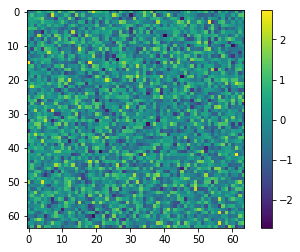

In [34]:
im = plt.imshow(noise[0,...,0].sum(axis=0))
plt.colorbar(im)

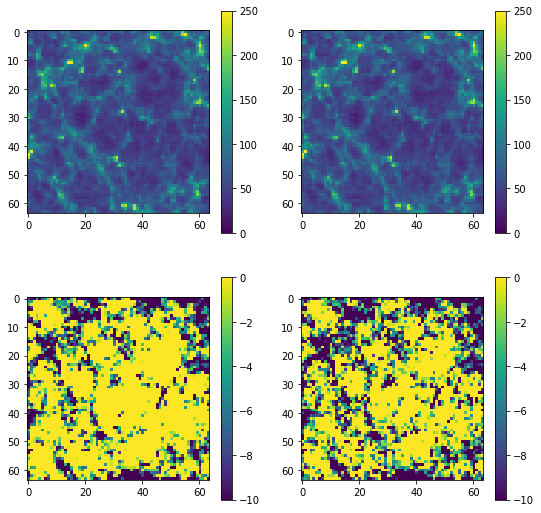

In [35]:
x1, x2 = 0, -1
fig, ax = plt.subplots(2, 2, figsize = (9, 9))
im = ax[0, 0].imshow(xxm[0,x1:x2,...,0].sum(axis=0), vmin=0, vmax=250)
plt.colorbar(im, ax=ax[0, 0])
im = ax[0, 1].imshow((xxm+noise)[0,x1:x2,...,0].sum(axis=0), vmin=0, vmax=250)
plt.colorbar(im, ax=ax[0, 1])
im = ax[1, 0].imshow(dmloglik[0, x1:x2,...].sum(axis=0), vmin=-10, vmax=0)
plt.colorbar(im, ax=ax[1, 0])
im = ax[1, 1].imshow(dmloglik0[0,x1:x2,...].sum(axis=0), vmin=-10, vmax=0)
plt.colorbar(im, ax=ax[1, 1])



In [36]:
sigmadm0.min(), sigmadm0.max()

(0.15112042, 1.0433784)

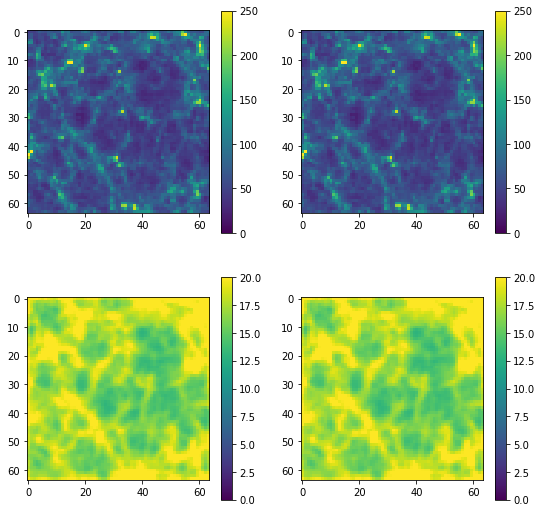

In [37]:
fig, ax = plt.subplots(2, 2, figsize = (9, 9))
im = ax[0, 0].imshow(xxm[0,...,0].sum(axis=0), vmin=0, vmax=250)
plt.colorbar(im, ax=ax[0, 0])
im = ax[0, 1].imshow((xxm+noise)[0,...,0].sum(axis=0), vmin=0, vmax=250)
plt.colorbar(im, ax=ax[0, 1])
im = ax[1, 0].imshow(sigmadm[0,...,0].sum(axis=0), vmin=0, vmax=20)
plt.colorbar(im, ax=ax[1, 0])
im = ax[1, 1].imshow(sigmadm0[0,...,0].sum(axis=0), vmin=0, vmax=20)
plt.colorbar(im, ax=ax[1, 1])



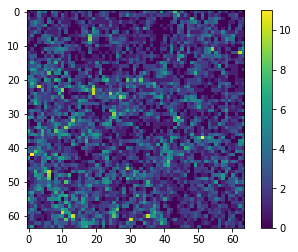

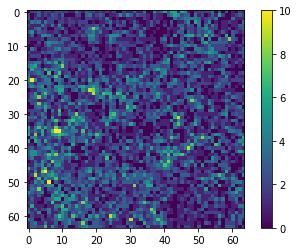

In [38]:
im = imshow(preds[1,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)
plt.show()
im = imshow(targets[1,:,:,:,0].sum(axis=-1))
plt.colorbar(im)


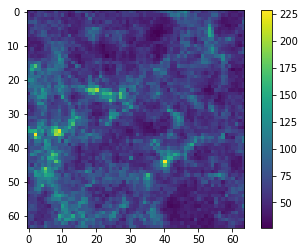

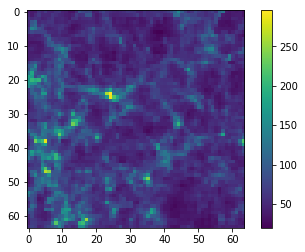

In [39]:
im = imshow((np.exp(predsdm[1,:,:,:])-1).sum(axis=-1))
plt.colorbar(im)
plt.show()
im = imshow(features[1,:,:,:,0].sum(axis=-1))
plt.colorbar(im)

## Do the testing for the whole box

In [40]:
tf.reset_default_graph()

module = hub.Module(modulepath + '/likelihood/')
module_inf = hub.Module(modulepath + '/inference/')

# module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')

xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']
sampledm = module_inf(dict(features=xx, labels=yy), as_dict=True)['sample']
regloglik = module_inf(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']

preds = {}
predsdm = {}
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    for seed in seeds:
        xxm = np.pad(meshes[seed][0]['cic'], pad, 'wrap')
        xxm = np.expand_dims(np.expand_dims(xxm,  -1), 0)

        yym = np.stack([meshes[seed][1]['pnn']], axis=-1)
        yym = np.expand_dims(yym, 0)
        preds[seed] = sess.run(samples, feed_dict={xx:xxm, yy:yym})
        meshes[seed][0]['predict'] = np.squeeze(preds[seed][:, :, :])
        predsdm[seed] = sess.run(sampledm, feed_dict={xx:xxm, yy:yym})
        meshes[seed][0]['predictdm'] = np.exp(np.squeeze(predsdm[seed][:, :, :]))-1
        
#         yym = np.stack([meshes[seed][1]['pnncen'], meshes[seed][1]['pnnsat']], axis=-1)
#         yym = np.expand_dims(yym, 0)
#         preds[seed] = sess.run(samples, feed_dict={xx:xxm, yy:yym})
#         meshes[seed][0]['predictcen'] = preds[seed][:, :, :, 0]
#         meshes[seed][0]['predictsat'] = preds[seed][:, :, :, 1]
        


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.


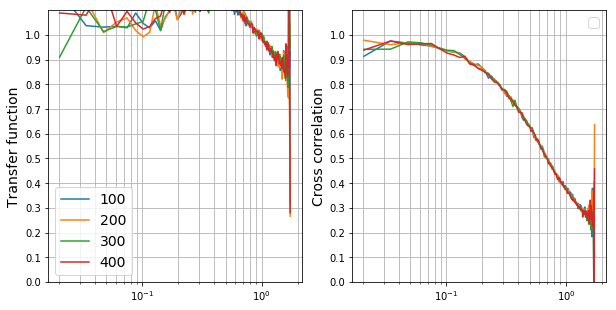

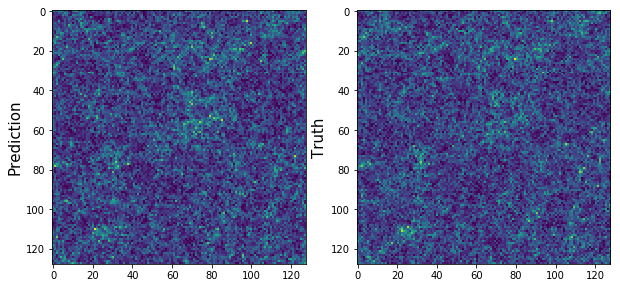

In [41]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for seed in seeds:
    key = ''
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
    ax[1].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0].set_ylabel('Transfer function', fontsize=14)
ax[1].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(1, 2, figsize=(10,5))

key = ''
predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Prediction', fontsize=15)
ax[1].set_ylabel('Truth', fontsize=15)
plt.show()


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.


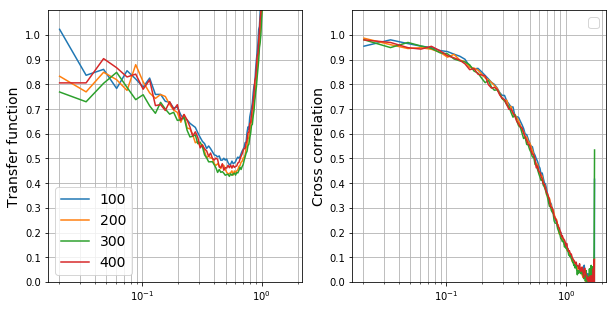

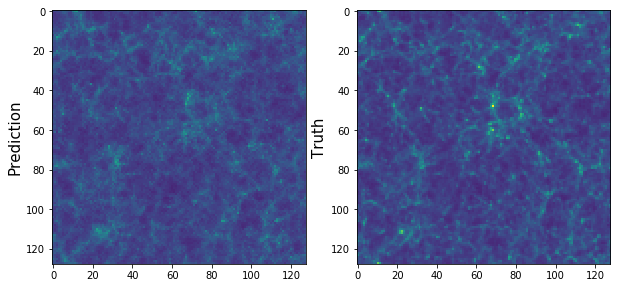

In [42]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for seed in seeds:
    key = ''
    predict, hpmeshd = meshes[seed][0]['predictdm'] , meshes[seed][0]['cic'], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
    ax[1].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0].set_ylabel('Transfer function', fontsize=14)
ax[1].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(1, 2, figsize=(10,5))

key = ''
predict, hpmeshd = meshes[seed][0]['predictdm%s'%key] , meshes[seed][0]['cic%s'%key], 
vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Prediction', fontsize=15)
ax[1].set_ylabel('Truth', fontsize=15)
plt.show()


In [25]:
(meshes[100][0]['cic'].flatten() ==0).sum()



11962

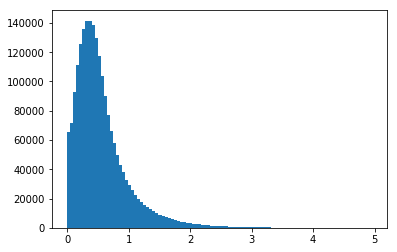

In [26]:
xx = np.log1p(meshes[100][0]['cic'].flatten())
# xx = np.log1p(meshes[100][0]['R1'].flatten())
plt.hist(xx, bins=100)
xx /= xx.mean()
# xx -= 1
# plt.hist(xx, bins=200, alpha=0.5)
plt.show()

In [27]:
# ##############################
# ##Power spectrum
# shape = [nc,nc,nc]
# kk = tools.fftk(shape, bs)
# kmesh = sum(i**2 for i in kk)**0.5

# fig, ax = plt.subplots(2, 3, figsize = (12, 8))
# for seed in seeds:
#     for i, key in enumerate(['cen', 'sat']):
#         predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
#         k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
#         k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
#         k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
#     ##
#         ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
#         ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
#         ax[0, i].set_title(key, fontsize=12)

#     i=2
#     predict, hpmeshd = meshes[seed][0]['predictcen']+meshes[seed][0]['predictsat'] ,\
#         meshes[seed][1]['pnncen']+meshes[seed][1]['pnnsat']
#     k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
#     k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
#     k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
# ##
#     ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
#     ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
# for axis in ax.flatten():
#     axis.legend(fontsize=14)
#     axis.set_yticks(np.arange(0, 1.1, 0.1))
#     axis.grid(which='both')
#     axis.set_ylim(0.,1.1)
# ax[0, 0].set_title('All Gal', fontsize=15)
# ax[0, 0].set_ylabel('Transfer function', fontsize=14)
# ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
# plt.show()

# # ##################################################
# fig, ax = plt.subplots(2, 3, figsize=(12,8))

# for i, key in enumerate([ 'cen', 'sat']):
#     predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
#     vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
#     im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
#     im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
#     ax[0, i].set_title(key, fontsize=15)
# i=2
# predict, hpmeshd = meshes[seed][0]['predictcen']+meshes[seed][0]['predictsat'] ,\
#         meshes[seed][1]['pnncen']+meshes[seed][1]['pnnsat']
# im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
# im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
# ax[0, 0].set_title('All Gal', fontsize=15)
# ax[0, 0].set_ylabel('Prediction', fontsize=15)
# ax[1, 0].set_ylabel('Truth', fontsize=15)
# plt.show()
